# Notebook to experiment with waveforms to inject

In [1]:
import sys
sys.path.append('../../shared')
from inject_tools import *

from pathlib import Path
from os.path import isfile, join
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Load a 64s segment of LIGO Hanford strain data

In [55]:
gps = event_gps('GW150914') - 100
segment = ((gps) - 32, (gps) + 32)
hdata = TimeSeries.fetch_open_data('H1', *segment, sample_rate=4*4096, verbose=True, cache=True)

params_path = Path('../../shared/injection_params')
sky_loc = pd.read_csv(join(params_path, 'sky_loc_csv.csv'))

ra = sky_loc['ra'][0]
dec = sky_loc['dec'][0]
pol = sky_loc['pol'][0]
alpha = sky_loc['alpha'][0]

print(ra, dec, pol, alpha)

Fetched 1 URLs from www.gw-openscience.org for [1126259330 .. 1126259395))
Reading data... [Done]
2.5772667350754466 0.5750598509460285 0.9046363684919756 0.19454772715176416


/anaconda2/envs/gw_env/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


In [56]:
d = Detector('H1')
fp, fc = d.antenna_pattern(ra, dec, pol, t_inj)

Set injection waveform family and the amplitude - A

In [66]:
# inj_type = 'sg' # sine-gaussian
# inj_type = 'rd' # ring-down
# inj_type = 'ga' # gaussian pulse
# inj_type = 'cg' # decreasing sweep
inj_type = 'cg_inc' # increasing sweep
# inj_type = 'cg_double' # double sweep
# inj_type = 'wn' # white noise

# A = 4.5e-21
# h_rss_target = 10e-22
# alpha = 0

A = 30e-22
times = hdata.times.value
t_inj = gps

Generate waveform according the waveform family, and set the relevant parameters

In [67]:
if inj_type == 'sg':
    f0 = 70
    Q = 100
    tau = Q / (np.sqrt(2) * np.pi * f0)
    Hp, Hc = sine_gaussian(times, t_inj, f0, Q)

elif inj_type == 'rd':
    f0 = 70
    tau = 200e-3
    Hp, Hc = ringdown(times, gps, f0, tau)

elif inj_type == 'ga':
    tau = 1e-3
    Hp, Hc = gaussian(times, gps, tau)

elif inj_type == 'cg':
    f0 = 70
    Q = 100
    tau = Q / (np.sqrt(2) * np.pi * f0)
    t1 = tau
    f1 = f0 / 2
    Hp, Hc = chirp_gaussian(times, t_inj, f0, t1, f1, Q, method='linear')

elif inj_type == 'cg_inc':
    f0 = 70
    Q = 100
    tau = Q / (np.sqrt(2) * np.pi * f0)
    t1 = tau
    f1 = f0 * 20
    Hp, Hc = chirp_gaussian_inc(times, t_inj, f0, t1, f1, Q, method='linear')

elif inj_type == 'cg_inc':
    f0 = 70
    Q = 100
    tau = Q / (np.sqrt(2) * np.pi * f0)
    t1 = tau
    f1 = f0 * 20
    f2 = f0 * 1.2
    a = 0.2
    Hp, Hc = double_chirp_gaussian(times, t_inj, f0, t1, f1, a, f2, Q, method='linear')

elif inj_type == 'wn':
    f_low = 250
    f_high = 350
    tau = 0.1
    Hp, Hc = white_noise(times, t_inj, f_low, f_high, tau)

hp, hc = gen_waveform(A, alpha, Hp, Hc)

Put generated waveform into TimeSeries class for injection and calculate h_rss

In [68]:
hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
hc = TimeSeries(hc, t0=times[0], dt=hdata.dt)
try:
    hp = hp.taper()
    hc = hc.taper()
except:
    print('Warning: no taper')

h_rss = np.sqrt((hp.dot(hp) + hc.dot(hc)) * hp.dt).value
print(h_rss / 1e-22)

# hp *= h_rss_target / h_rss
# hc *= h_rss_target / h_rss

hp *= A / h_rss
hc *= A / h_rss

h_rss = np.sqrt((hp.dot(hp) + hc.dot(hc)) * hp.dt).value
print(h_rss / 1e-22)

7.464025152989151
30.0


In [69]:
h = fp * hp + fc * hc

Plot the waveform to be injected and the injected LIGO data

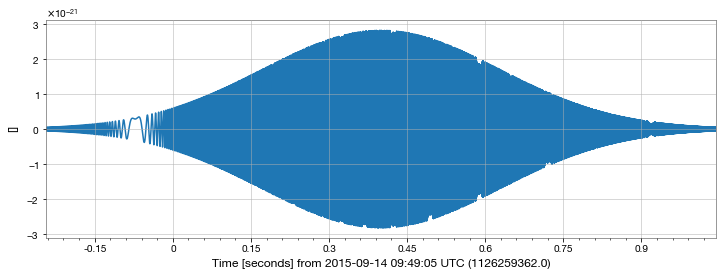

In [70]:
t_snr = 2 * tau
# plot = hp.crop(gps - t_snr, gps + t_snr).plot()
# plot = hc.crop(gps - t_snr, gps + t_snr).plot()
plot = h.crop(gps - t_snr, gps + t_snr).plot()
plt.show()

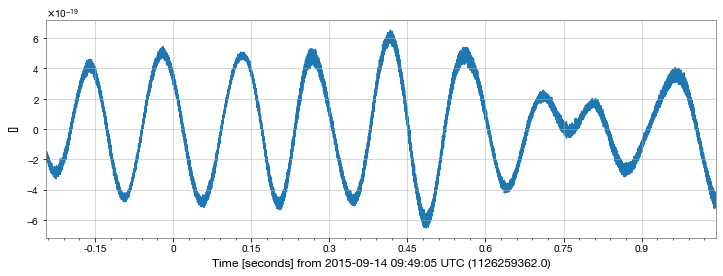

In [71]:
waveform_data = hdata.inject(h)
plot = waveform_data.crop(gps - t_snr, gps + t_snr).plot()
plt.show()

Generate and plot constant-Q transform of the injected signal

In [72]:
qt = waveform_data.q_transform(frange=(10, 2048), qrange=(4, 64), whiten=True, tres=0.002)

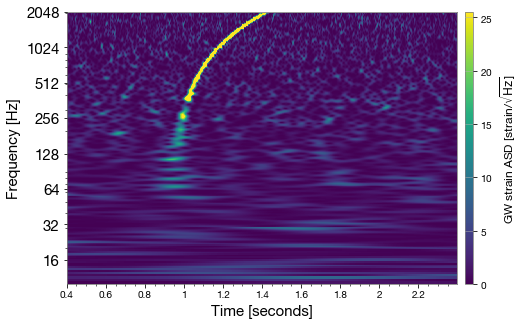

In [73]:
size = (7, 5)
plot = qt.crop(gps - 1, gps + 1).plot(figsize=size, vmin=0, vmax=25.5)
ax = plot.gca()
ax.set_ylim(10, 2048)
ax.set_yscale('log')
ax.colorbar(label='GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]')
ax.grid(False)
plt.xlabel('Time [seconds]', size=15)
plt.ylabel('Frequency [Hz]', size=15)
ytick_list = [16, 32, 64, 128, 256, 512, 1024, 2048]
ax.set_yticks(ytick_list)
ax.set_yticklabels([str(tick) for tick in ytick_list], size=15)
plot.show()

Load waveform parameters file and for each set of parameters calculate h_rss

In [44]:
data_path = Path('../../shared/injection_params')
# inj_type = 'sg' # sine-gaussian
# inj_type = 'rd' # ring-down
# inj_type = 'ga' # gaussian pulse
# inj_type = 'cg' # decreasing sweep
# inj_type = 'cg_inc' # increasing sweep
# inj_type = 'cg_double' # double sweep
inj_type = 'wn' # white noise

h_rss = []

if inj_type == 'sg' or inj_type == 'cg' or inj_type == 'cg_inc' or inj_type == 'cg_double':
    params = pd.read_csv(join(data_path, inj_type + '_params_csv.csv'), usecols=['f0', 'Q', 'A'])
    for f0, Q, A in tqdm(zip(params['f0'], params['Q'], params['A']), total=len(params['f0'])):
        if inj_type == 'sg':
            Hp, Hc = sine_gaussian(times, t_inj, f0, Q)
        
        elif inj_type == 'cg':
            t1 = tau
            f1 = f0 / 2
            Hp, Hc = sine_gaussian_chirp(times, t_inj, f0, t1, f1, Q, method='linear')

        elif inj_type == 'cg_inc':
            t1 = tau
            f1 = f0 * 20
            Hp, Hc = sine_gaussian_chirp_inc(times, t_inj, f0, t1, f1, Q, method='linear')

        elif inj_type == 'cg_double':
            t1 = tau
            f1 = f0 * 20
            f2 = f0 * 1.2
            if f0 == 30:
                a = 0.6
            elif f0 == 70:
                a = 0.2
            Hp, Hc = sine_gaussian_chirp_double(times, t_inj, f0, t1, f1, a, f2, Q, method='linear')
        
        hp, hc = gen_waveform(A, alpha, Hp, Hc)
        hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
        hc = TimeSeries(hc, t0=times[0], dt=hdata.dt)
        try:
            hp = hp.taper()
            hc = hc.taper()
        except:
            pass
        h_rss.append(np.sqrt(hp.dot(hp) * hp.dt).value)

elif inj_type == 'rd':
    params = pd.read_csv(join(data_path, inj_type + '_params_csv.csv'), usecols=['f0', 'tau', 'A'])
    for f0, tau, A in tqdm(zip(params['f0'], params['tau'], params['A']), total=len(params['f0'])):
        Hp, Hc = ringdown(times, gps, f0, tau)
        hp, hc = gen_waveform(A, alpha, Hp, Hc)
        hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
        hc = TimeSeries(hc, t0=times[0], dt=hdata.dt)
        try:
            hp = hp.taper()
            hc = hc.taper()
        except:
            pass
        h_rss.append(np.sqrt(hp.dot(hp) * hp.dt).value)

elif inj_type == 'ga':
    params = pd.read_csv(join(data_path, inj_type + '_params_csv.csv'), usecols=['tau', 'A'])
    for tau, A in tqdm(zip(params['tau'], params['A']), total=len(params['tau'])):
        Hp, Hc = gaussian(times, gps, tau)
        hp, hc = gen_waveform(A, alpha, Hp, Hc)
        hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
        hc = TimeSeries(hc, t0=times[0], dt=hdata.dt)
        try:
            hp = hp.taper()
            hc = hc.taper()
        except:
            pass
        h_rss.append(np.sqrt(hp.dot(hp) * hp.dt).value)

elif inj_type == 'wn':
    params = pd.read_csv(join(data_path, inj_type + '_params_csv.csv'), usecols=['f_low', 'f_high', 'tau', 'A'])
    for f_low, f_high, tau, A in tqdm(zip(params['f_low'], params['f_high'], params['tau'], params['A']), 
                                      total=len(params['f_low'])):
        Hp, Hc = white_noise(times, t_inj, f_low, f_high, tau)
        hp, hc = gen_waveform(A, alpha, Hp, Hc)
        hp = TimeSeries(hp, t0=times[0], dt=hdata.dt)
        hc = TimeSeries(hc, t0=times[0], dt=hdata.dt)
        try:
            hp = hp.taper()
            hc = hc.taper()
        except:
            pass
        h_rss.append(np.sqrt(hp.dot(hp) * hp.dt).value)

params['h_rss'] = h_rss
# display(params)
# params.to_csv(join(data_path, inj_type + '_params_csv.csv'))

100%|██████████| 8/8 [00:45<00:00,  5.68s/it]


,f_low,f_high,tau,A,h_rss
0,100,200,0.1,2.800000e-20,5.235230e-22
1,100,200,0.1,5.600000e-20,8.896826e-22
2,100,200,0.1,1.120000e-19,1.791101e-21
3,100,200,0.1,1.680000e-19,2.456725e-21
4,250,350,0.1,2.900000e-20,4.717747e-22
5,250,350,0.1,5.800000e-20,7.722313e-22
6,250,350,0.1,1.160000e-19,2.309442e-21
7,250,350,0.1,1.740000e-19,2.578160e-21
